## Control vs. Everything

From request [New ML Analyses](https://trello.com/c/PWNhnPEw)

Run the following models: 

Control vs. PD
Control vs. MSA
Control vs. PSP 

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_random_seed = 55

## 7. Control vs. PD

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.95        63
        1.0       0.99      0.94      0.96        95

avg / total       0.96      0.96      0.96       158


Confusion matrix, without normalization
[[62  1]
 [ 6 89]]

recall	0.936842105263
precision	0.988888888889
auc	0.960484544695
specificity	0.984126984127
npv	0.911764705882
accuracy	0.955696202532
weighted_sensitivity	0.936842105263
weighted_ppv	0.983339179235
weighted_specificity	0.984126984127
weighted_npv	0.939693682195
weighted_accuracy	0.960484544695


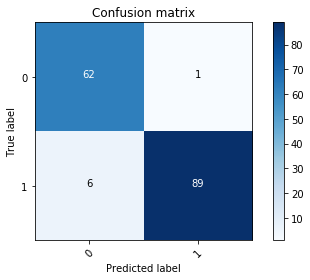

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.102518987656	0.00423887151284
score_time	0.0345142841339	0.00117193583513
test_recall	0.932702237522	0.0195366108415
train_recall	0.968750678389	0.00305558452568
test_precision	0.972842267413	0.0136079937342
train_precision	0.987767182106	0.0038150047463
test_auc	0.940769723412	0.00963203678568
train_auc	0.972747432218	0.00350113277129
test_specificity	0.948837209302	0.0271207064877
train_specificity	0.976744186047	0.00735413409341
test_npv	0.880818818554	0.029355777598
train_npv	0.941742962063	0.00525924648897
test_accuracy	0.938207724034	0.00914176778389
train_accuracy	0.971475719	0.00266940209021
test_weighted_sensitivity	0.932702237522	0.0195366108415
train_weighted_sensitivity	0.968750678389	0.00305558452568
test_weighted_ppv	0.949023508495	0.0250188873382
train_weighted_ppv	0.976617407418	0.00724643739237
test_weighted_specificity	0.948837209302	0.0271207064877
train_weighted_specificity	0.976744186047	0.00735413409341
test_weighted_npv	0.934396654984	0.0169890706963
t

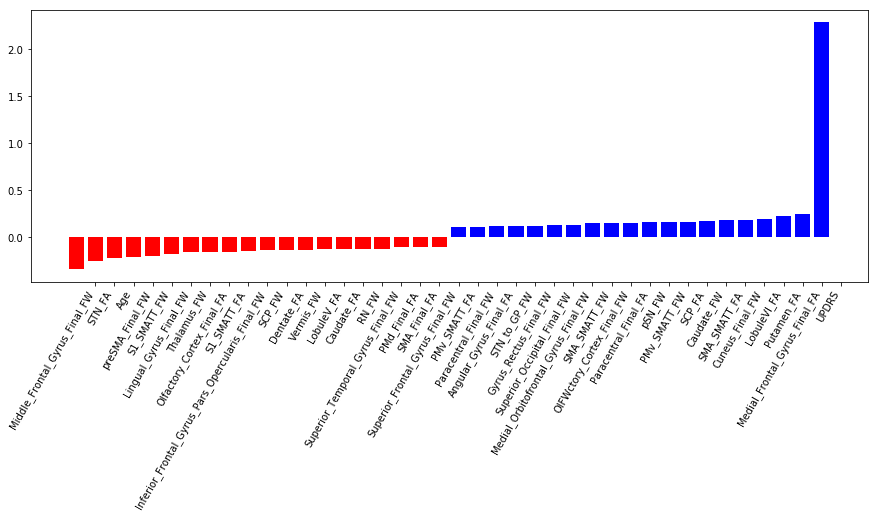

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.225958034562
Sex	-0.0285116798316
UPDRS	2.29015325526
aSN_FA	-0.0865043036593
Caudate_FA	-0.136203983286
CC2_FA	0.0182320940133
GP_FA	-0.0546765731201
LobuleVI_FA	0.185393822557
LobuleV_FA	-0.136661310104
MCP_FA	0.101748407009
pSN_FA	0.094228935145
Putamen_FA	0.217196336801
SCP_FA	0.159820444244
STN_FA	-0.262692101649
Thalamus_FA	0.0690612334891
Vermis_FA	0.047326570597
RN_FA	0.093398717214
PPN_FA	-0.0660204341818
Dentate_FA	-0.145272213398
CC1_FA	0.0017727610131
aSN_FW	0.0475199659717
Caudate_FW	0.171657261567
CC2_FW	0.0402386110771
GP_FW	0.064702343626
LobuleVI_FW	0.0285984501795
LobuleV_FW	0.0918450397392
MCP_FW	-0.0460520722481
pSN_FW	0.156537295724
Putamen_FW	0.00584171897538
SCP_FW	-0.145726871423
STN_FW	-0.104337768841
Thalamus_FW	-0.166462989337
Vermis_FW	-0.14171381
RN_FW	-0.136072354621
PPN_FW	-0.0851281440985
Dentate_FW	0.000965217117943
CC1_FW	-0.0452173317634
Angular_Gyrus_Final_FA	0.111499788145
Anterior_Orbital_Gyrus_Final_FA	-0.0510409638091
Calcarine_Sulcus_Fina

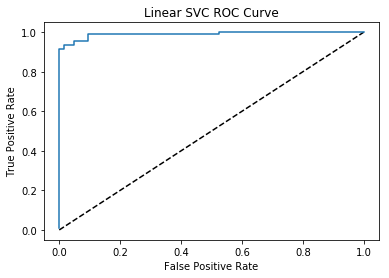

0.0 0.0105263157895
0.0 0.915789473684
0.015873015873 0.915789473684
0.015873015873 0.936842105263
0.047619047619 0.936842105263
0.047619047619 0.957894736842
0.0952380952381 0.957894736842
0.0952380952381 0.989473684211
0.52380952381 0.989473684211
0.52380952381 1.0
1.0 1.0


In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 8. Control vs MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99        62
        1.0       0.92      1.00      0.96        11

avg / total       0.99      0.99      0.99        73


Confusion matrix, without normalization
[[61  1]
 [ 0 11]]

recall	1.0
precision	0.916666666667
auc	0.991935483871
specificity	0.983870967742
npv	1.0
accuracy	0.986301369863
weighted_sensitivity	1.0
weighted_ppv	0.984126984127
weighted_specificity	0.983870967742
weighted_npv	1.0
weighted_accuracy	0.991935483871


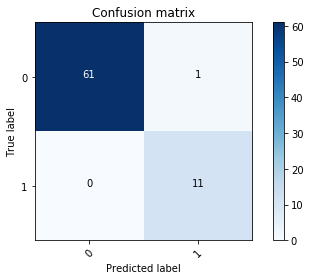

In [7]:
# Get the data
data2 = group_classes(_data, {0:0, 2:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0173983573914	0.000770407470362
score_time	0.0117834568024	0.00123266983316
test_recall	0.972380952381	0.0338597882564
train_recall	1.0	0.0
test_precision	0.960714285714	0.051010203061
train_precision	0.983273131425	0.010371697048
test_auc	0.979213732004	0.0186165652935
train_auc	0.997106465923	0.0018279185193
test_specificity	0.986046511628	0.0186046511628
train_specificity	0.994212931846	0.0036558370386
test_npv	0.990803382664	0.0112647499406
train_npv	1.0	0.0
test_accuracy	0.982516636419	0.0156921715581
train_accuracy	0.99567469512	0.00272613745979
test_weighted_sensitivity	0.972380952381	0.0338597882564
train_weighted_sensitivity	1.0	0.0
test_weighted_ppv	0.986224549156	0.0180191875825
train_weighted_ppv	0.994259365775	0.00361411600049
test_weighted_specificity	0.986046511628	0.0186046511628
train_weighted_specificity	0.994212931846	0.0036558370386
test_weighted_npv	0.973870839937	0.0320513184526
train_weighted_npv	1.0	0.0
test_weighted_accuracy	0.979213732004	0.01861656

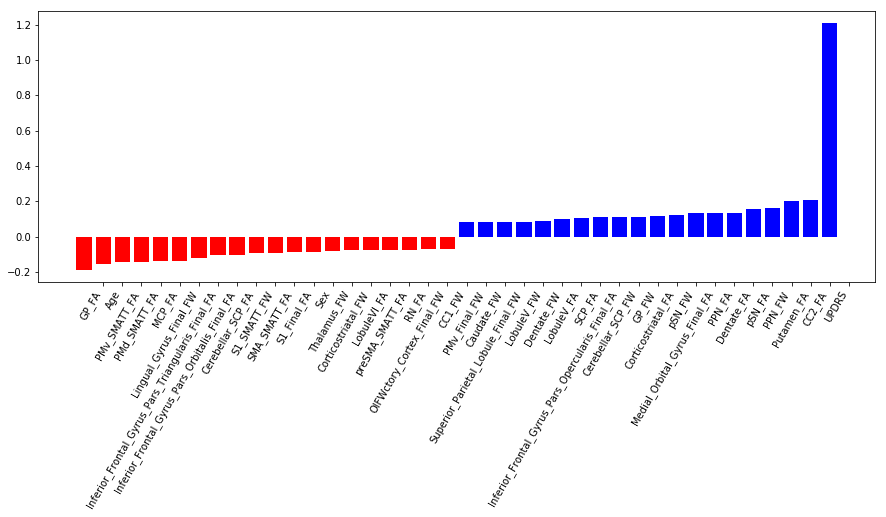

Age	-0.155944031376
Sex	-0.0844873981283
UPDRS	1.21018200759
aSN_FA	0.0643012769779
Caudate_FA	-0.0171961848136
CC2_FA	0.21029167844
GP_FA	-0.188979324051
LobuleVI_FA	-0.0783322486279
LobuleV_FA	0.100489229016
MCP_FA	-0.137165091364
pSN_FA	0.158670073772
Putamen_FA	0.199683645057
SCP_FA	0.103604114542
STN_FA	0.058352563549
Thalamus_FA	-0.0499078000083
Vermis_FA	0.00259162391312
RN_FA	-0.0740665189549
PPN_FA	0.13248677242
Dentate_FA	0.133750198012
CC1_FA	0.0425953175714
aSN_FW	0.0215202618936
Caudate_FW	0.0817525493884
CC2_FW	0.0563610543938
GP_FW	0.112457933332
LobuleVI_FW	-0.0292842655172
LobuleV_FW	0.085284684945
MCP_FW	0.0338227458234
pSN_FW	0.12188142924
Putamen_FW	0.0163167056542
SCP_FW	0.0150654811159
STN_FW	0.0649763580198
Thalamus_FW	-0.081854904424
Vermis_FW	-0.0181497403915
RN_FW	-0.0205109435719
PPN_FW	0.160425441617
Dentate_FW	0.0886047117474
CC1_FW	-0.072494221031
Angular_Gyrus_Final_FA	0.0208770233967
Anterior_Orbital_Gyrus_Final_FA	-0.00912190497648
Calcarine_Sulcus_Fina

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99        62
        1.0       0.92      1.00      0.96        11

avg / total       0.99      0.99      0.99        73



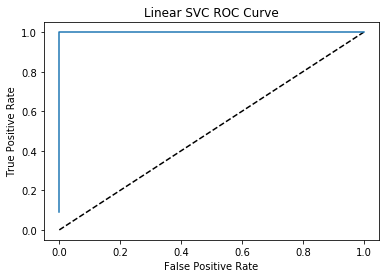

0.0 0.0909090909091
0.0 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 9. Control vs PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        59
        1.0       1.00      1.00      1.00        23

avg / total       1.00      1.00      1.00        82


Confusion matrix, without normalization
[[59  0]
 [ 0 23]]

recall	1.0
precision	1.0
auc	1.0
specificity	1.0
npv	1.0
accuracy	1.0
weighted_sensitivity	1.0
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	1.0
weighted_accuracy	1.0


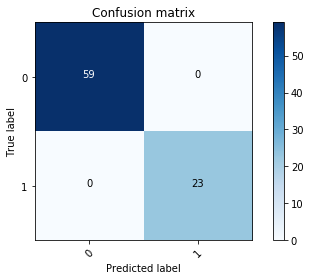

In [11]:
# Get the data
data3 = group_classes(_data, {0:0, 3:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0202020168304	0.00121095887982
score_time	0.0133138179779	0.000382188221685
test_recall	0.915584415584	0.0542422687712
train_recall	0.969383753501	0.0140803607029
test_precision	0.915465838509	0.0348635802072
train_precision	0.955859171255	0.00423405295849
test_auc	0.937231954092	0.0314853195402
train_auc	0.973847720907	0.00644611299087
test_specificity	0.9588794926	0.0170691814148
train_specificity	0.978311688312	0.00227328379086
test_npv	0.959595959596	0.0261633711045
train_npv	0.985109336882	0.00678068147851
test_accuracy	0.944752331002	0.0247057939455
train_accuracy	0.975387448836	0.00390918929234
test_weighted_sensitivity	0.915584415584	0.0542422687712
train_weighted_sensitivity	0.969383753501	0.0140803607029
test_weighted_ppv	0.956811964967	0.0185597757928
train_weighted_ppv	0.978135377253	0.00211473974579
test_weighted_specificity	0.9588794926	0.0170691814148
train_weighted_specificity	0.978311688312	0.00227328379086
test_weighted_npv	0.921361556094	0.0498388581493
tr

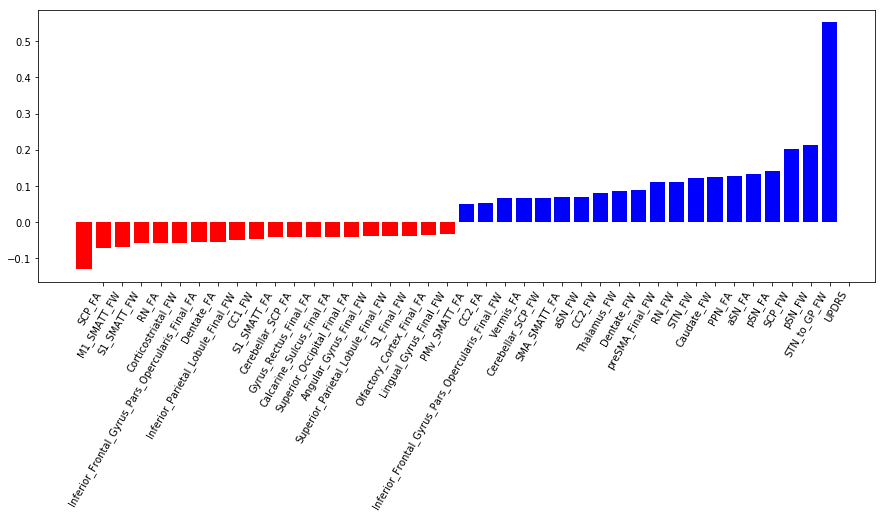

Age	0.0425826675249
Sex	0.0115646991537
UPDRS	0.553356368444
aSN_FA	0.127873411772
Caudate_FA	-0.0110050174581
CC2_FA	0.0501038038212
GP_FA	0.0464480059295
LobuleVI_FA	0.0318863734779
LobuleV_FA	0.00445599982915
MCP_FA	0.0146710816
pSN_FA	0.13158971118
Putamen_FA	-0.0171449779784
SCP_FA	-0.131809719437
STN_FA	-0.00889928088896
Thalamus_FA	0.0479415970148
Vermis_FA	0.064469495459
RN_FA	-0.0603856368031
PPN_FA	0.124672745934
Dentate_FA	-0.0572136852927
CC1_FA	0.0134413430477
aSN_FW	0.06791085085
Caudate_FW	0.119942605237
CC2_FW	0.0697778954006
GP_FW	-0.000880731240849
LobuleVI_FW	-0.0205412863094
LobuleV_FW	0.0312241165296
MCP_FW	0.0188600855324
pSN_FW	0.202297020925
Putamen_FW	-0.0173390893036
SCP_FW	0.141374881866
STN_FW	0.111146990051
Thalamus_FW	0.0790308645724
Vermis_FW	-0.0115046718291
RN_FW	0.109240266038
PPN_FW	0.0150593021919
Dentate_FW	0.0855342393984
CC1_FW	-0.0497097603063
Angular_Gyrus_Final_FA	0.0342273307772
Anterior_Orbital_Gyrus_Final_FA	-0.00353692859517
Calcarine_Sulcu

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        59
        1.0       1.00      1.00      1.00        23

avg / total       1.00      1.00      1.00        82



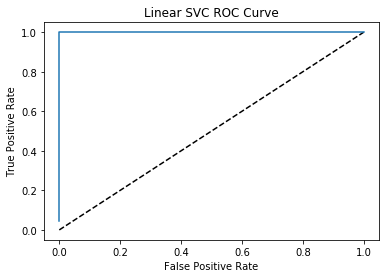

0.0 0.0434782608696
0.0 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)